<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
    <h2>Специализация "Машинное обучение и анализ данных"</h2>
</center>
<center>

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам

# <center>Финальный отчёт

## Цели проекта

Данная работы выполнена в рамках учебного соревнования Kaggle Catch Me If You Can ("Alice") (https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2)

Из описания задачи соревнования:

_Будем решать задачу идентификации взломщика по его поведению в сети Интернет. 
Aлгоритм будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой)._

_Данные собраны с прокси-серверов Университета Блеза Паскаля. "A Tool for Classification of Sequential Data", авторы Giacomo Kahn, Yannick Loiseau и Olivier Raynaud._

Целевая метрика – ROC AUC.

## Источники данных

Данные для проекта предоставлены на странице сореванования и доступны по ссылке: https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/data



In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import warnings
import statsmodels.api as sm

warnings.filterwarnings("ignore")

In [4]:
PATH_TO_DATA = "..\data"
dt_columns = ["time%d" % i for i in range(1, 11)]
site_columns = ["site%d" % i for i in range(1, 11)]

### train_sessions.csv
В файле находят данные для обучения моделей. В нём содержатся данные по сессиям пользователей. Каждая сессия представляет не более 10 сайтов и не более 30 минут. Более длинные сессии разбиваются на несколько.

Признаки site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем site_dic.pkl)

Признаки time_j – время посещения сайтов site_j

Целевой признак target – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам)

In [5]:
train_df = pd.read_csv(
    os.path.join(PATH_TO_DATA, "train_sessions.csv"),
    index_col="session_id",
    parse_dates=dt_columns,
)
train_df.head()

site1               time1  site2               time2    site3  \
session_id                                                                  
1             718 2014-02-20 10:02:45    NaN                 NaT      NaN   
2             890 2014-02-22 11:19:50  941.0 2014-02-22 11:19:50   3847.0   
3           14769 2013-12-16 16:40:17   39.0 2013-12-16 16:40:18  14768.0   
4             782 2014-03-28 10:52:12  782.0 2014-03-28 10:52:42    782.0   
5              22 2014-02-28 10:53:05  177.0 2014-02-28 10:55:22    175.0   

                         time3    site4               time4  site5  \
session_id                                                           
1                          NaT      NaN                 NaT    NaN   
2          2014-02-22 11:19:51    941.0 2014-02-22 11:19:51  942.0   
3          2013-12-16 16:40:19  14769.0 2013-12-16 16:40:19   37.0   
4          2014-03-28 10:53:12    782.0 2014-03-28 10:53:42  782.0   
5          2014-02-28 10:55:22    178.0 2014-02-28 10:55:23  177.0   

                         time5  ...               time6    site7  \
session_id                      ...                                
1                          NaT  ...                 NaT      NaN   
2          2014-02-22 11:19:51  ... 2014-02-22 11:19:51   3847.0   
3          2013-12-16 16:40:19  ... 2013-12-16 16:40:19  14768.0   
4          2014-03-28 10:54:12  ... 2014-03-28 10:54:42    782.0   
5          2014-02-28 10:55:23  ... 2014-02-28 10:55:59    175.0   

                         time7    site8               time8    site9  \
session_id                                                             
1                          NaT      NaN                 NaT      NaN   
2          2014-02-22 11:19:52   3846.0 2014-02-22 11:19:52   1516.0   
3          2013-12-16 16:40:20  14768.0 2013-12-16 16:40:21  14768.0   
4          2014-03-28 10:55:12    782.0 2014-03-28 10:55:42    782.0   
5          2014-02-28 10:55:59    177.0 2014-02-28 10:55:59    177.0   

                         time9   site10              time10 target  
session_id                                                          
1                          NaT      NaN                 NaT      0  
2          2014-02-22 11:20:15   1518.0 2014-02-22 11:20:16      0  
3          2013-12-16 16:40:22  14768.0 2013-12-16 16:40:24      0  
4          2014-03-28 10:56:12    782.0 2014-03-28 10:56:42      0  
5          2014-02-28 10:57:06    178.0 2014-02-28 10:57:11      0  

[5 rows x 21 columns]

### test_sessions.csv
В файле находятся сессии, которые надо классифицировать в рамках соревнования: кому они принадлежат Элис или нет. Структура файла аналогична train_sessions.csv, но нет колонки target

In [4]:
test_df = pd.read_csv(
    os.path.join(PATH_TO_DATA, "test_sessions.csv"),
    index_col="session_id",
    parse_dates=dt_columns,
)
test_df.head()

site1               time1   site2               time2  site3  \
session_id                                                                 
1              29 2014-10-04 11:19:53    35.0 2014-10-04 11:19:53   22.0   
2             782 2014-07-03 11:00:28   782.0 2014-07-03 11:00:53  782.0   
3              55 2014-12-05 15:55:12    55.0 2014-12-05 15:55:13   55.0   
4            1023 2014-11-04 10:03:19  1022.0 2014-11-04 10:03:19   50.0   
5             301 2014-05-16 15:05:31   301.0 2014-05-16 15:05:32  301.0   

                         time3  site4               time4  site5  \
session_id                                                         
1          2014-10-04 11:19:54  321.0 2014-10-04 11:19:54   23.0   
2          2014-07-03 11:00:58  782.0 2014-07-03 11:01:06  782.0   
3          2014-12-05 15:55:14   55.0 2014-12-05 15:56:15   55.0   
4          2014-11-04 10:03:20  222.0 2014-11-04 10:03:21  202.0   
5          2014-05-16 15:05:33   66.0 2014-05-16 15:05:39   67.0   

                         time5   site6               time6   site7  \
session_id                                                           
1          2014-10-04 11:19:54  2211.0 2014-10-04 11:19:54  6730.0   
2          2014-07-03 11:01:09   782.0 2014-07-03 11:01:10   782.0   
3          2014-12-05 15:56:16    55.0 2014-12-05 15:56:17    55.0   
4          2014-11-04 10:03:21  3374.0 2014-11-04 10:03:22    50.0   
5          2014-05-16 15:05:40    69.0 2014-05-16 15:05:40    70.0   

                         time7  site8               time8    site9  \
session_id                                                           
1          2014-10-04 11:19:54   21.0 2014-10-04 11:19:54  44582.0   
2          2014-07-03 11:01:23  782.0 2014-07-03 11:01:29    782.0   
3          2014-12-05 15:56:18   55.0 2014-12-05 15:56:19   1445.0   
4          2014-11-04 10:03:22   48.0 2014-11-04 10:03:22     48.0   
5          2014-05-16 15:05:40   68.0 2014-05-16 15:05:40     71.0   

                         time9   site10              time10  
session_id                                                   
1          2014-10-04 11:20:00  15336.0 2014-10-04 11:20:00  
2          2014-07-03 11:01:30    782.0 2014-07-03 11:01:53  
3          2014-12-05 15:56:33   1445.0 2014-12-05 15:56:36  
4          2014-11-04 10:03:23   3374.0 2014-11-04 10:03:23  
5          2014-05-16 15:05:40    167.0 2014-05-16 15:05:44

### sample_submission.csv
В файле находится пример того, как нужно загружать результаты на сайт соревнования

In [5]:
pd.read_csv(
    os.path.join(PATH_TO_DATA, "sample_submission.csv"), index_col="session_id"
).head()

target
session_id          
1           0.948255
2           0.682483
3           0.502855
4           0.345556
5           0.889428

### site_dic.pkl
В файле хранится pickle дамп словаря {site_id: site_url}

In [6]:
with open(os.path.join(PATH_TO_DATA, "site_dic.pkl"), "rb") as site_dict_file:
    site_dict = pickle.load(site_dict_file)

list(site_dict.items())[:10]

[('www.abmecatronique.com', 25075),
 ('groups.live.com', 13997),
 ('majeureliguefootball.wordpress.com', 42436),
 ('cdt46.media.tourinsoft.eu', 30911),
 ('www.hdwallpapers.eu', 8104),
 ('img378.imageshack.us', 37491),
 ('ecologie.nature.free.fr', 5462),
 ('www.ibcn.intec.ugent.be', 35425),
 ('kissanime.com', 30151),
 ('www.carolineconduiteformation.com', 38268)]

## Aнализ признаков

In [6]:
import matplotlib.pyplot as plt
import datetime

In [8]:
train_df_alice = train_df[train_df.target == 1]
train_df_rest = train_df[train_df.target == 0]

### Посещенные сайты
Признаки site_j скорее всего не будут иметь смысла в задаче классификации сессий, т.к. маловероятно, что порядковый номер в сессии будет иметь значение. Эти признаки больше похожи на bag of words, поэтому их надо будет преобразовать в подобный формат.

### Время работы в интернете

In [9]:
# session start: minutes after 00:00
day_minutes_alice = (
    train_df_alice.time1.dt.hour * 60 + train_df_alice.time1.dt.minute
).value_counts()
day_minutes_rest = (
    train_df_rest.time1.dt.hour * 60 + train_df_rest.time1.dt.minute
).value_counts()
plt.figure(figsize=(15, 5))
plt.hist(
    [train_df_alice.time1.dt.hour, train_df_rest.time1.dt.hour],
    density=True,
    label=["Alice", "Others"],
    bins=range(0, 25),
    edgecolor="w",
    align="right",
)
plt.xlabel("Час в сутках")
plt.ylabel("% сессий")
plt.legend()
plt.xticks(ticks=range(1, 25), labels=range(0, 24))
plt.show()

Alice появляется в интернете меньше, чем все остальные. Пики работы так же не совпадают. Время в сутках стоит учитывать, как признак.

Есть часы, когда Alice появляется редко. Надо отдельно проверить распределение времени внутри часа.

In [10]:
train_df_alice.time1.dt.hour.value_counts().sort_index()

9      38
11      3
12    340
13    196
14      4
15     40
16    879
17    618
18    179
Name: time1, dtype: int64

Нужно проверить распределение внутри часов 9, 11, 14, 15, 18

In [11]:
hours = [9, 11, 14, 15, 18]
fig, ax = plt.subplots(nrows=len(hours), ncols=1, figsize=(15, 10))
for i, h in enumerate(hours):
    minutes = train_df_alice[train_df_alice.time1.dt.hour == h].time1.dt.minute
    ax[i].hist(
        minutes, bins=range(0, 60), edgecolor="w", align="right", label="час=%d" % h
    )
    ax[i].legend()
    ax[i].set_xlabel("минуты")
    ax[i].set_ylabel("кол-во")

plt.show()

Судя по всему Alice появляется в сети в 2 определённых промежутка времени. Нужно исследовать их границы. Возможно, есть связь с днями недели.

### День недели и время

In [12]:
pd.crosstab(train_df_alice.time1.dt.day_of_week, train_df_alice.time1.dt.hour)

time1  9   11   12   13  14  15   16   17   18
time1                                         
0       0   0    0    0   0   9  445  311  111
1       0   1  107   36   1   3  152  169   39
2       0   0    0    0   0   6    6   16   10
3       0   0   57   32   0  22  276   87   13
4      38   1  176  128   3   0    0    0    0
5       0   0    0    0   0   0    0   35    6
6       0   1    0    0   0   0    0    0    0

Есть ли часы, в которые Alice была в сети только в один день?

In [13]:
# find hours when Alice was in Internet only on 1-2 particular dates
print("Alice в эти часы была в интернете только в 1-2 даты")
for h in np.unique(train_df_alice.time1.dt.hour):
    days = train_df_alice[
        train_df_alice.time1.dt.hour == h
    ].time1.dt.date.value_counts()
    if len(days) <= 2:
        print("Час:", h, days.index.values)

Alice в эти часы была в интернете только в 1-2 даты
Час: 9 [datetime.date(2013, 4, 12)]
Час: 14 [datetime.date(2013, 11, 15) datetime.date(2014, 1, 28)]


В 9 часов Alice была активна только в один день, причём сессий в этот день было много. Это нетипичное поведение и эти сессии надо убрать из обучения.

Alice сидит в Интернете в разные дни в разное время. Достаточно ли данных, чтобы принять решение, что в разные дни Alice сидит в интернете в разное время?

In [14]:
for d in sorted(np.unique(train_df_alice.time1.dt.day_of_week)):
    print("Day:", d)
    print(
        sorted(
            np.unique(
                train_df_alice[
                    train_df_alice.time1.dt.day_of_week == d
                ].time1.dt.date.apply(datetime.date.isoformat)
            )
        )
    )

Day: 0
['2013-11-18', '2013-12-16', '2014-01-20', '2014-02-17', '2014-02-24', '2014-03-24', '2014-03-31', '2014-04-14']
Day: 1
['2013-02-12', '2013-11-19', '2013-12-17', '2014-01-14', '2014-01-28', '2014-02-18', '2014-02-25', '2014-03-18', '2014-03-25', '2014-04-15']
Day: 2
['2014-04-02']
Day: 3
['2013-09-12', '2014-01-16', '2014-02-13', '2014-02-20', '2014-02-27', '2014-03-20']
Day: 4
['2013-04-12', '2013-11-15', '2013-11-22', '2013-11-29']
Day: 5
['2014-01-04']
Day: 6
['2014-03-02']


Понедельник. Данных достаточно. Видимо, Alice сидит в интернете только во второй половине дня.

Вторник, Четверг. Данных достаточно. Alice появляется в сети до обеда и ближе к концу рабочего дня.

Среда. Данных мало. Есть только вечерняя активность, то наверняка сказаться нельзя. Лучше выбрать промежуток, как у остальных рабочих дней.

Пятница. Данные достаточно. Alice появляется в сети до обеда.

Суббота и Воскресенье. Данных мало. Лучше выбрать промежуток, который больше соответствует большинству дней.

Анализ промежутка границ промежутков времени, в которых Alice появляется в Интернете.

In [15]:
periods = [[11, 14], [15, 18]]

fig, ax = plt.subplots(ncols=2, figsize=(10, 3))

for i, p in enumerate(periods):
    times = train_df_alice[
        (train_df_alice.time1.dt.hour >= p[0]) & (train_df_alice.time1.dt.hour <= p[1])
    ].time1.dt.time
    time_seconds = [x.hour * 3600 + x.minute * 60 + x.second for x in times]
    q_low, q_high = np.quantile(time_seconds, [0.025, 0.975])
    lower_bound = (
        datetime.datetime(1900, 1, 1) + datetime.timedelta(seconds=q_low)
    ).time()
    upper_bound = (
        datetime.datetime(1900, 1, 1) + datetime.timedelta(seconds=q_high)
    ).time()
    print(
        "Период часов активности [{0}, {1}]. Левая граница: {2}. Правая граница: {3}".format(
            p[0], p[1], lower_bound, upper_bound
        )
    )
    ax[i].boxplot(time_seconds)
    ax[i].set_ylabel("секунды в сутках")
    ax[i].set_xlabel("Часы %d - %d" % (p[0], p[1]))

fig.tight_layout()

Период часов активности [11, 14]. Левая граница: 12:06:06.600000. Правая граница: 13:49:55.150000
Период часов активности [15, 18]. Левая граница: 16:00:36. Правая граница: 18:12:14.625000


In [16]:
np.unique(train_df_alice.time1.dt.hour)
alice_timing = []
alice_hours = np.unique(train_df_alice.time1.dt.hour)
for d in range(0, 7):
    day_timing = []
    for h in alice_hours:
        ds = train_df_alice[
            (train_df_alice.time1.dt.day_of_week == d)
            & (train_df_alice.time1.dt.hour == h)
        ]
        day_timing.append(np.min(ds.time1.dt.time))
        day_timing.append(np.max(ds.time1.dt.time))
    alice_timing.append(day_timing)
pd.DataFrame(
    alice_timing,
    columns=[x for h in alice_hours for x in ((str(h) + "_first", str(h) + "_last"))],
)

9_first    9_last  11_first   11_last  12_first   12_last  13_first  \
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1       NaN       NaN  11:53:25  11:53:25  12:03:18  12:59:49  13:00:59   
2       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3       NaN       NaN       NaN       NaN  12:29:33  12:58:57  13:02:02   
4  09:02:48  09:26:15  11:59:01  11:59:01  12:13:22  12:59:59  13:00:33   
5       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
6       NaN       NaN  11:55:52  11:55:52       NaN       NaN       NaN   

    13_last  14_first   14_last  15_first   15_last  16_first   16_last  \
0       NaN       NaN       NaN  15:57:42  15:59:54  16:00:13  16:59:33   
1  13:50:09  14:14:19  14:14:19  15:54:33  15:57:21  16:00:36  16:59:59   
2       NaN       NaN       NaN  15:56:20  15:57:02  16:03:44  16:05:03   
3  13:47:49       NaN       NaN  15:00:28  15:55:50  16:00:36  16:59:57   
4  13:57:40  14:02:50  14:04:08       NaN       NaN       NaN       NaN   
5       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
6       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

   17_first   17_last  18_first   18_last  
0  17:00:21  17:59:52  18:00:10  18:19:24  
1  17:00:03  17:59:49  18:00:49  18:13:05  
2  17:09:22  17:49:58  18:01:47  18:09:01  
3  17:00:25  17:59:56  18:00:45  18:20:54  
4       NaN       NaN       NaN       NaN  
5  17:29:19  17:57:45  18:09:16  18:11:07  
6       NaN       NaN       NaN       NaN

Распределение времени остальных пользователей

In [17]:
pd.crosstab(train_df_rest.time1.dt.day_of_week, train_df_rest.time1.dt.hour)

time1  7     8     9     10    11    12    13    14    15    16    17   18  \
time1                                                                        
0      43  3671  4472  5012  5317  2055  4108  4145  3528  3478  2091  540   
1      72  5599  6456  6576  5220  3014  3651  6137  4180  3121  2603  636   
2      72  6538  8520  7479  7672  4260  4245  4959  4841  4191  2052  559   
3      63  4356  4956  4917  4823  3113  4679  5725  3756  3186  2472  782   
4      55  2899  4306  7087  5412  3551  4086  4006  3472  2512  1832  558   
5      26  1965  2626  2191  1910   583   766  1241   981   758   644  364   
6      10   341   367   414   441   504   821  1089   842   614   518  280   

time1   19   20   21   22   23  
time1                           
0      328  227  298  183  141  
1      240  136  126  195  189  
2       81   74  147  118  125  
3      287  112  161  125  147  
4      209  210  245  231  123  
5      169  272  466  367  429  
6      226  169  262  248  185

Остальные сидят в сети более равномерно

Нужно попробовать использовать 2 промежутка времени в качестве признака, что сессия принадлежит Alice:
- [12:06:06, 13:49:55]
- [16:00:36, 18:12:14]

Стоит попробовать выбирать один или два промежутка в зависимости от дня недели. Однако это может оказаться неверным решением, т.к. в обучающей выборке мало данных. Текущее распределение промежутков по дням недели может оказаться случайным.

### Дни работы в Интернете

In [18]:
plt.figure(figsize=(10, 5))
bins = len(train_df.time1.dt.dayofweek.value_counts())
plt.hist(
    [train_df_alice.time1.dt.dayofweek, train_df_rest.time1.dt.dayofweek],
    density=True,
    label=["Alice", "Others"],
    bins=range(0, 8),
    edgecolor="w",
    align="right",
)
plt.xlabel("День недели")
plt.ylabel("% сессий")
plt.xticks(ticks=range(1, 8), labels=["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"])
plt.legend()
plt.show()

Недельный график Alice явно отличается от остальных. День недели нужно использовать, как признак.

### Месячный график

In [19]:
plt.figure(figsize=(15, 5))
bins = len(train_df.time1.dt.dayofweek.value_counts())
plt.hist(
    [train_df_alice.time1.dt.month, train_df_rest.time1.dt.month],
    density=True,
    label=["Alice", "Others"],
    bins=list(range(1, 14)),
    edgecolor="w",
    align="right",
)
plt.xlabel("Месяц")
plt.ylabel("% сессий")
plt.xticks(
    ticks=range(2, 14),
    labels=[
        "Янв",
        "Фев",
        "Мар",
        "Апр",
        "Май",
        "Июнь",
        "Июль",
        "Авг",
        "Сен",
        "Окт",
        "Ноя",
        "Дек",
    ],
)
plt.legend()
plt.show()

Alice сидит в Интернете не круглый год. Возможно, что надо использовать месяц или декаду дней от начала года в качестве признака.

Нужно проверить распределение дней в "крайних" месяцах и около нового года.

In [20]:
train_df_alice.time1.dt.month.value_counts().sort_index()

1     129
2     471
3     400
4     340
9     377
11    446
12    134
Name: time1, dtype: int64

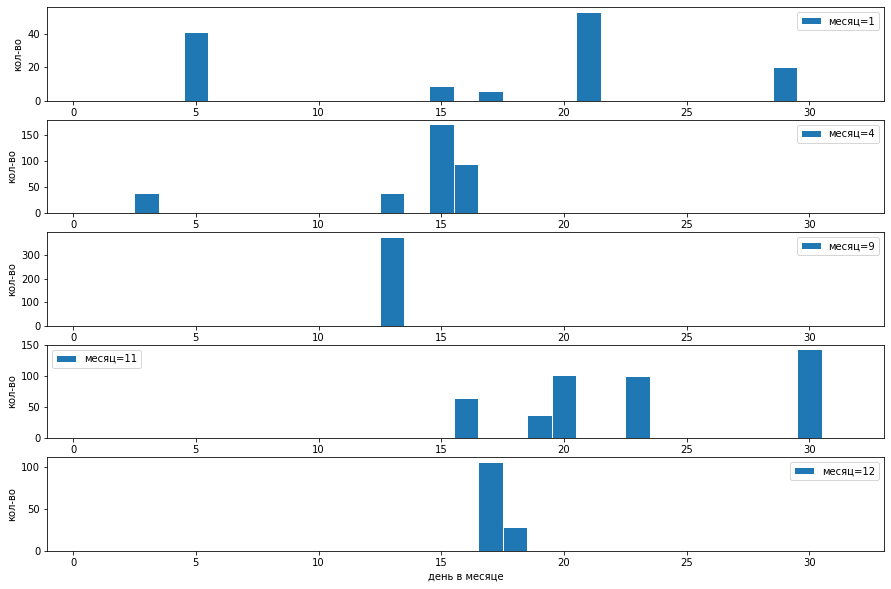

In [21]:
months = [1, 4, 9, 11, 12]
fig, ax = plt.subplots(nrows=len(months), ncols=1, figsize=(15, 10))
for i, m in enumerate(months):
    minutes = train_df_alice[train_df_alice.time1.dt.month == m].time1.dt.day
    ax[i].hist(
        minutes, bins=range(0, 32), edgecolor="w", align="right", label="месяц=%d" % m
    )
    ax[i].legend()
    ax[i].set_xlabel("день в месяце")
    ax[i].set_ylabel("кол-во")

plt.show()

Хорошей зависимости не видно, но можно отдельно проверить Новый год.

In [22]:
print(
    "Временной промежуток тренировочной сессии: {0} - {1}".format(
        train_df[dt_columns].min().min(), train_df[dt_columns].max().max()
    )
)
print(
    "Временной промежуток тестовой сессии: {0} - {1}".format(
        test_df[dt_columns].min().min(), test_df[dt_columns].max().max()
    )
)

Временной промежуток тренировочной сессии: 2013-01-12 08:05:57 - 2014-04-30 23:40:05
Временной промежуток тестовой сессии: 2014-05-01 17:14:03 - 2014-12-05 23:56:23


Тестовая сессия в другом периоде. Признак Нового года не имеет смысла.

Летнее расписание могло поменяться. Возможно, что добавление месяца только ухудшит прогноз.

### Недельный график

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax[0].plot(train_df_alice.time1.dt.week.value_counts().sort_index(), label="Alice")
ax[1].plot(
    train_df_rest.time1.dt.week.value_counts().sort_index(),
    label="Others",
    color="darkorange",
)
for a in ax:
    a.set_xlabel("Недели")
    a.set_ylabel("Кол-во сессий")
    a.legend()
plt.show()

Распределение по неделями выглядит сильно отличающимся, можно попробовать использовать в качестве признака.

In [24]:
train_df_alice.time1.dt.week.value_counts().sort_index()

1      41
3      15
4      53
5      20
7     140
8     138
9     194
12     10
13    367
14     60
15     38
16    264
37    377
46     65
47    238
48    143
51    134
Name: time1, dtype: int64

Есть перерывы в неделях: 2, 6, 49, 50. На какие недели приходятся тестовые данные?

In [25]:
test_df.time1.dt.week.value_counts().sort_index()

18    10048
19      304
20     7228
21     5606
22     4021
23     2838
27    10837
31     3729
32     4117
36     3627
40     8157
44     6378
45     3519
49    12388
Name: time1, dtype: int64

Стоит дополнить данные для обучения неделей 49.

### Длина сессии (сайты)

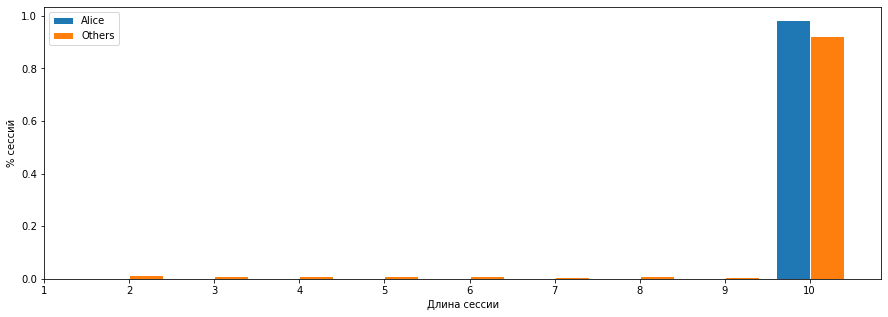

In [26]:
sites_count_alice = len(site_columns) - np.sum(
    train_df_alice[site_columns].isna(), axis=1
)
sites_count_rest = len(site_columns) - np.sum(
    train_df_rest[site_columns].isna(), axis=1
)
plt.figure(figsize=(15, 5))
plt.hist(
    [sites_count_alice, sites_count_rest],
    density=True,
    label=["Alice", "Others"],
    bins=range(2, 12),
    edgecolor="w",
    align="right",
)
plt.xlabel("Длина сессии")
plt.ylabel("% сессий")
plt.legend()
plt.xticks(ticks=range(2, 12), labels=range(1, 11))
plt.show()

В основном сессии имеют длину 10. Надо посмотреть отдельно сессии длиины меньше 10.

In [27]:
sites_count_alice_9 = sites_count_alice[sites_count_alice != 10]
sites_count_rest_9 = sites_count_rest[sites_count_rest != 10]
plt.figure(figsize=(15, 5))
plt.hist(
    [sites_count_alice_9, sites_count_rest_9],
    density=True,
    label=["Alice", "Others"],
    bins=range(1, 11),
    edgecolor="w",
    align="right",
)
plt.xlabel("Длина сессии")
plt.ylabel("% сессий")
plt.legend()
plt.xticks(ticks=range(2, 11), labels=range(1, 10))
plt.show()

По некоторым сессиям разница есть. Можно добавить, как категориальный признак.

По некоторым сессиям разница есть. Можно добавить, как категориальный признак.

### Длина сессии (время)

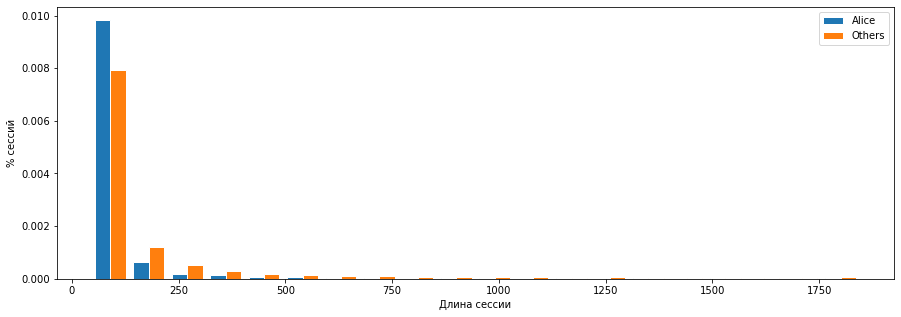

In [28]:
session_time_alice = (
    np.max(train_df_alice[dt_columns], axis=1)
    - np.min(train_df_alice[dt_columns], axis=1)
).dt.seconds
session_time_rest = (
    np.max(train_df_rest[dt_columns], axis=1)
    - np.min(train_df_rest[dt_columns], axis=1)
).dt.seconds
session_time_all = (
    np.max(train_df[dt_columns], axis=1) - np.min(train_df[dt_columns], axis=1)
).dt.seconds
plt.figure(figsize=(15, 5))
plt.hist(
    [session_time_alice, session_time_rest],
    density=True,
    label=["Alice", "Others"],
    bins=20,
    edgecolor="w",
    align="right",
)
plt.xlabel("Длина сессии")
plt.ylabel("% сессий")
plt.legend()
plt.show()

Отдельно короткие сессии

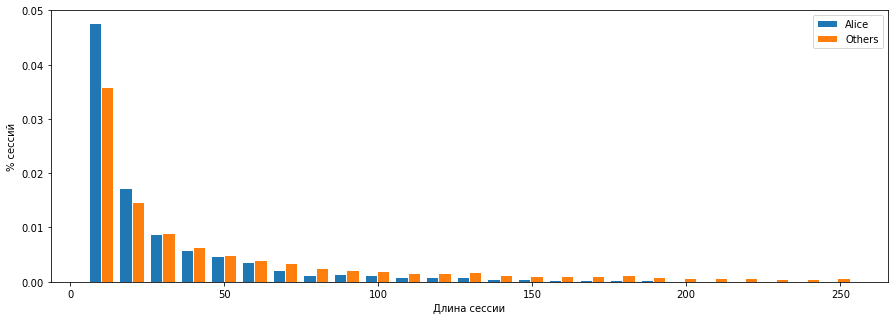

In [29]:
session_time_alice = session_time_alice[session_time_alice < 250]
session_time_rest = session_time_rest[session_time_rest < 250]
plt.figure(figsize=(15, 5))
plt.hist(
    [session_time_alice, session_time_rest],
    density=True,
    label=["Alice", "Others"],
    bins=25,
    edgecolor="w",
    align="right",
)
plt.xlabel("Длина сессии")
plt.ylabel("% сессий")
plt.legend()
plt.show()

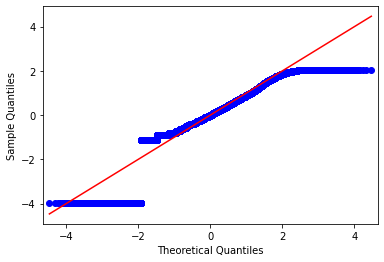

In [30]:
sm.qqplot(session_time_all**0.1, fit=True, line="s")
plt.show()

### Количество уникальных сайтов в сессии

In [31]:
sites_unique_alice = train_df_alice[site_columns].nunique(axis=1)
sites_unique_rest = train_df_rest[site_columns].nunique(axis=1)
sites_unique_all = train_df[site_columns].nunique(axis=1)

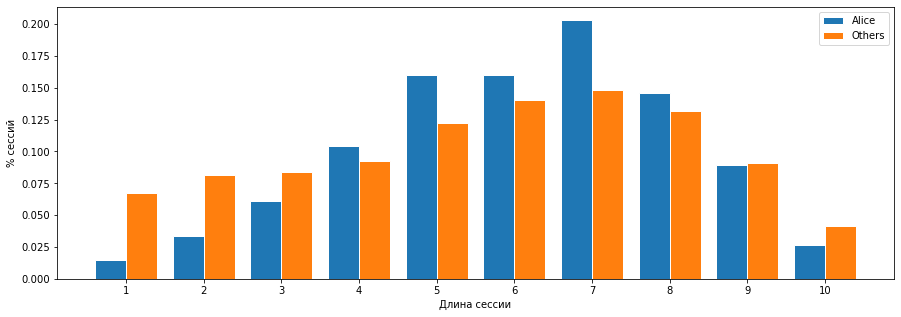

In [32]:
plt.figure(figsize=(15, 5))
plt.hist(
    [sites_unique_alice, sites_unique_rest],
    density=True,
    label=["Alice", "Others"],
    bins=range(1, 12),
    edgecolor="w",
    align="right",
)
plt.xlabel("Длина сессии")
plt.ylabel("% сессий")
plt.legend()
plt.xticks(ticks=range(2, 12), labels=range(1, 11))
plt.show()

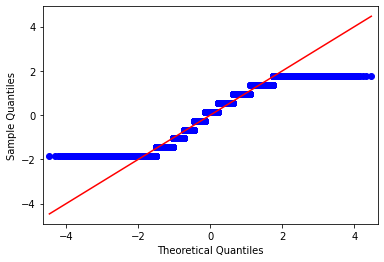

In [33]:
sm.qqplot(sites_unique_all, fit=True, line="s")
plt.show()

### Среднее время на сайт

In [34]:
time_per_site_alice = session_time_alice / sites_count_alice
time_per_site_rest = session_time_rest / sites_count_rest
sites_count_all = len(site_columns) - np.sum(train_df[site_columns].isna(), axis=1)
time_per_site_all = session_time_all / sites_count_all
plt.figure(figsize=(15, 5))
plt.hist(
    [time_per_site_alice, time_per_site_rest],
    density=True,
    label=["Alice", "Others"],
    bins=10,
    edgecolor="w",
    align="right",
)
plt.xlabel("Среднее время на одном сайте (сек)")
plt.ylabel("% сессий")
plt.legend()
plt.show()

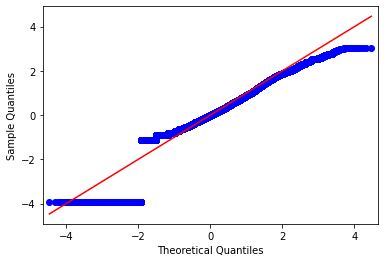

In [35]:
sm.qqplot(time_per_site_all**0.1, fit=True, line="s")
plt.show()

### Различия в посещаемых сайтах

In [36]:
# load sites dictionary
with open(os.path.join(PATH_TO_DATA, "site_dic.pkl"), "rb") as site_dict_file:
    site_dict = pickle.load(site_dict_file)

list(site_dict.items())[:10]

site_dict_reverse = {code: site for (site, code) in site_dict.items()}

In [37]:
alice_site_count = (
    train_df_alice[site_columns]
    .applymap(site_dict_reverse.get)
    .melt()
    .value.value_counts()
)
alice_site_count.to_csv("alice_site_count.csv")
alice_site_count.head(20)

i1.ytimg.com                            1382
s.youtube.com                           1354
www.youtube.com                         1307
www.facebook.com                         897
www.google.fr                            857
r4---sn-gxo5uxg-jqbe.googlevideo.com     609
r1---sn-gxo5uxg-jqbe.googlevideo.com     522
apis.google.com                          522
s.ytimg.com                              451
r2---sn-gxo5uxg-jqbe.googlevideo.com     447
www.google.com                           437
s-static.ak.facebook.com                 381
r3---sn-gxo5uxg-jqbe.googlevideo.com     371
twitter.com                              293
static.ak.facebook.com                   291
vk.com                                   286
translate.google.fr                      274
platform.twitter.com                     272
yt3.ggpht.com                            236
mts0.google.com                          215
Name: value, dtype: int64

Судя по всему Alice любит смотреть видео контент. выбираем всё, что связано с видео и аудио. Ключевые слова после анализа сайтов Alice:

ytimg, youtube, video, movie, stream, cinema, film, tv, yt3, youwatch, media, mtv, music, radio

Какие сайты интересны остальным пользователям?

In [38]:
rest_site_count = (
    train_df_rest[site_columns]
    .applymap(site_dict_reverse.get)
    .melt()
    .value.value_counts()
)
rest_site_count.to_csv("rest_site_count.csv")
rest_site_count.head(15)

www.google.fr                    122919
www.google.com                    87182
annotathon.org                    77055
apis.google.com                   57736
www.facebook.com                  53197
www.bing.com                      46355
blast.ncbi.nlm.nih.gov            43841
www.ncbi.nlm.nih.gov              38194
clients1.google.com               35879
mail.google.com                   35178
plus.google.com                   30616
s.youtube.com                     30037
safebrowsing-cache.google.com     27812
accounts.google.com               25154
twitter.com                       23433
Name: value, dtype: int64

Можно ли сделать различие между сайтами, которые посещает Alice и остальные?

Какую часть от всех запросов составляют топ-сайты. 

In [39]:
print("Часть от всех запросов Alice, которые покрывают топ-сайты")
top_head = 100
alice_site_rolling = (
    alice_site_count.head(top_head).rolling(window=top_head, min_periods=1).sum()
    / alice_site_count.sum()
)
for i in range(19, top_head, 20):
    print(
        "Alice топ-{0} сайтов покрывают {1} от всех сайтов".format(
            i + 1, alice_site_rolling[i]
        )
    )

print("\nЧасть от всех запросов остальных, которые покрывают топ-сайты")
top_head = 300
rest_site_rolling = (
    rest_site_count.head(top_head).rolling(window=top_head, min_periods=1).sum()
    / rest_site_count.sum()
)
for i in range(39, top_head, 40):
    print(
        "Alice топ-{0} сайтов покрывают {1} от всех сайтов".format(
            i + 1, rest_site_rolling[i]
        )
    )

Часть от всех запросов Alice, которые покрывают топ-сайты
Alice топ-20 сайтов покрывают 0.5008564275989283 от всех сайтов
Alice топ-40 сайтов покрывают 0.6306820677236593 от всех сайтов
Alice топ-60 сайтов покрывают 0.6996793886424525 от всех сайтов
Alice топ-80 сайтов покрывают 0.7449602529755369 от всех сайтов
Alice топ-100 сайтов покрывают 0.7759234046291009 от всех сайтов

Часть от всех запросов остальных, которые покрывают топ-сайты
Alice топ-40 сайтов покрывают 0.4554508137906566 от всех сайтов
Alice топ-80 сайтов покрывают 0.5592510138650464 от всех сайтов
Alice топ-120 сайтов покрывают 0.6135669012861745 от всех сайтов
Alice топ-160 сайтов покрывают 0.6470686926255727 от всех сайтов
Alice топ-200 сайтов покрывают 0.6726382163840926 от всех сайтов
Alice топ-240 сайтов покрывают 0.6933606849221647 от всех сайтов
Alice топ-280 сайтов покрывают 0.7103293529045304 от всех сайтов


Насколько отличабются топ-сайты Alice и остальных?

In [40]:
alice_site_set = set(alice_site_count.head(40).index).difference(
    rest_site_count.head(250).index
)
alice_site_set

{'media.melty.fr',
 'vk.com',
 'www.info-jeunes.net',
 'www.melty.fr',
 'wwwd.caf.fr',
 'youwatch.org'}

Насколько отличабются топ-сайты остальных от Alice?

In [41]:
rest_site_set = set(rest_site_count.head(50).index).difference(alice_site_count.index)
rest_site_set

{'annotathon.org',
 'api.twitter.com',
 'blast.ncbi.nlm.nih.gov',
 'download.jboss.org',
 'fr-mg42.mail.yahoo.com',
 'fr.openclassrooms.com',
 'mail.google.com',
 'ocsp.digicert.com',
 'plus.google.com',
 'safebrowsing-cache.google.com',
 'safebrowsing.clients.google.com',
 'ts1.mm.bing.net',
 'www.ncbi.nlm.nih.gov',
 'www.phylogeny.fr'}

Стоит попробовать добавить признаки "любимых" сайтов Alice и остальных пользователей.

## Подготовка данных
Подготовка данных будет сделана при помощи стандартных классов sklearn и их расширений, которые будут объединяться при помощи паплайнов

In [7]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

### Baseline
Базовые признаки заданы самим Capstone-проектом: преобразование сессий с сайтами site1..site10 в мешок слов, где в качестве слов используются сайты. Каждый сайт считается независимым признаком, т.е. используются n-граммы (1, 1).

Размер обучающей выборки - 0.7. Размер тестовой выборки - 0.3. Предполагается, что порядок сессий имеет значение, поэтому в тренировочной выборке идёт начало всего датасета, в тестовой - конец.

In [8]:
class SitesPreparator(BaseEstimator, TransformerMixin):
    """
    Prepares CountVectorizer friendly list of strings with sites IDs
    Consumes pandas dataframe
    ----------
    Example
    [[1, 2, 3],
    [4, 5, 6]]
    --->
    ["1 2 3", "4 5 6"]
    """

    def __init__(self, site_columns):
        self.site_columns = site_columns
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X[self.site_columns].fillna(0).astype(int).values.tolist()
        return [" ".join(map(str, row)) for row in X]

In [44]:
sites_pipeline_base = Pipeline(
    [
        ("site_prep", SitesPreparator(site_columns)),
        (
            "site_vect",
            CountVectorizer(
                token_pattern=r"(?u)[1-9]\w*\b", ngram_range=(1, 1), max_features=50000
            ),
        ),
    ]
)

In [45]:
y_base = train_df.target
X_train_base_sparse = sites_pipeline_base.fit_transform(train_df[train_df.columns[:-1]])
X_test_base_sparse = sites_pipeline_base.transform(test_df)

# split train data to train and validation
train_share = int(0.7 * X_train_base_sparse.shape[0])
X_train_base, y_train_base = X_train_base_sparse[:train_share, :], y_base[:train_share]
X_valid_base, y_valid_base = X_train_base_sparse[train_share:, :], y_base[train_share:]

### Улучшения признаков
Признаки посещённых сайтов будут кодированы при помощи TF-IDF. n-граммы использованы вида (1, 3). Максимальное количество признаков - 50,000

Допонительно добавлены категориальные признаки. 
- alice_interested - признак, что сайт интересен для Alice
- rest_interested - признак, что сайт интересен остальным
- session_start - время начала сессии
- dayofweek - день недели
- sites_count - количество сайтов
- week - номер недели

Дополнительно добавлены числовые признаки:
- session_time - длительность сессии в секундах
- time_per_site - среднее время на сайт в сессии
- is_alice_time - признак, что Alice бывает активна в это время
- is_evening - признак вечернего времени
- is_morning - признаки утреннего времени 

Разделение на обучающую и тестовые выборки проводится при помощи случайной стратифицированной выборки. Размер обучающей выборки - 0.8 

In [46]:
class InterestsAttributeAddr(BaseEstimator, TransformerMixin):
    """
    Extracts interest of Alice and the rest of the people
    -------------------
    alice_interested - binary feature, if there is an interesting for Alice site in the session
    rest_interested - binary feature, if there is an interesting for the rest of the peiople site in the session
    """

    def __init__(self, site_columns, site_dict):
        self.site_columns = site_columns
        self.site_dict = site_dict
        self.alice_sites = []
        self.rest_sites = []
        super().__init__()

    def fit(self, X, y=None):
        #  Alice themes were observed during EDA
        alice_themes = {
            "ytimg",
            "youtube",
            "video",
            "movie",
            "stream",
            "cinema",
            "film",
            "tv",
            "yt3",
            "youwatch",
            "media",
            "mtv",
            "music",
            "radio",
        }
        X = X[self.site_columns].applymap(self.site_dict.get, na_action="ignore")
        # get counts of Alice's and rest of the people sites
        alice_site_count = X[y == 1].melt().value.value_counts()
        rest_site_count = X[y == 0].melt().value.value_counts()
        # get top different sites for Alice and rest
        self.rest_sites = set(rest_site_count.head(50).index).difference(
            alice_site_count.index
        )
        alice_site_set = set(alice_site_count.head(40).index).difference(
            rest_site_count.head(250).index
        )
        self.alice_sites = alice_themes.union(
            [
                site
                for site in alice_site_set
                if all([at not in site for at in alice_themes])
            ]
        )
        return self

    def transform(self, X):
        X = X[self.site_columns].applymap(self.site_dict.get, na_action="ignore")
        alice_interested = X.apply(
            self.check_interests, axis=1, args=(self.alice_sites,)
        )
        rest_interested = X.apply(self.check_interests, axis=1, args=(self.rest_sites,))
        return np.c_[alice_interested, rest_interested]

    def check_interests(self, row, interests_list):
        for site in row:
            if isinstance(site, str):
                for interest in interests_list:
                    if interest in site:
                        return 1
        return 0

In [47]:
class ExtAttributeAddr(BaseEstimator, TransformerMixin):
    """
    Creates additional categorical features
    -----------------
    dayofweek - day of week (0-6)
    month - # of month in year (0-11)
    sites_count - number of sites in session (1-10)
    week - # of week in year
    """

    def __init__(self, site_columns, date_columns):
        self.site_columns = site_columns
        self.date_columns = date_columns
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        dayofweek = X[self.date_columns[0]].dt.dayofweek
        month = X[self.date_columns[0]].dt.month
        sites_count = len(self.site_columns) - np.sum(X[site_columns].isna(), axis=1)
        week = X[self.date_columns[0]].dt.week
        # return np.c_[dayofweek, month, sites_count, week]
        return np.c_[dayofweek, sites_count, week]

In [48]:
class ExtNumericAttributeAddr(BaseEstimator, TransformerMixin):
    """
    Creates additional numeric features
    ------------------
    session_time - session duration in seconds
    time_per_site - average time per site
    is_alice_time - binary feature. 1 if Alice is active in the perion of time
    is_evening - binary feature. 1 if it's evening time
    is_morning - binary feature. 1 is it's morning time
    """

    def __init__(self, site_columns, date_columns):
        self.site_columns = site_columns
        self.date_columns = date_columns
        self.alice_sites = []
        self.rest_sites = []
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        sites_count = len(self.site_columns) - np.sum(
            X[self.site_columns].isna(), axis=1
        )
        session_time = (
            (
                np.max(X[self.date_columns], axis=1)
                - np.min(X[self.date_columns], axis=1)
            ).dt.seconds
        ) ** 0.1
        time_per_site = (session_time / sites_count) ** 0.1
        is_alice_time = X[self.date_columns[0]].apply(self.is_alice_time)
        is_evening = (X[self.date_columns[0]].dt.time > datetime.time(18, 30)).astype(
            int
        )
        is_morning = (X[self.date_columns[0]].dt.hour <= 11).astype(int)
        return np.c_[session_time, time_per_site, is_alice_time, is_evening, is_morning]

    def is_alice_time(self, dt):
        """
        The method returns 1 if time belongs to Alice's standard working hours, otherwise - 0
        """
        timetable = [
            # Mon
            [
                (datetime.time(12, 0), datetime.time(13, 50)),
                (datetime.time(15, 50), datetime.time(18, 20)),
            ],
            # Tue
            [
                (datetime.time(12, 0), datetime.time(13, 50)),
                (datetime.time(15, 50), datetime.time(18, 20)),
            ],
            # Wed
            [
                (datetime.time(15, 50), datetime.time(18, 20))
            ],  # Это случайный хак, полученный в результате оценки на Kaggle
            # Thur
            [
                (datetime.time(12, 0), datetime.time(13, 50)),
                (datetime.time(15, 50), datetime.time(18, 20)),
            ],
            # Fri
            [
                (datetime.time(12, 0), datetime.time(13, 50)),
                (datetime.time(15, 50), datetime.time(18, 20)),
            ],
            # Sat
            [
                (datetime.time(12, 0), datetime.time(13, 50)),
                (datetime.time(15, 50), datetime.time(18, 20)),
            ],
            # Sun
            [
                (datetime.time(12, 0), datetime.time(13, 50)),
                (datetime.time(15, 50), datetime.time(18, 20)),
            ],
        ]
        for start, end in timetable[dt.weekday()]:
            if dt.time() >= start and dt.time() <= end:
                return 1
        return 0

Удаление данных с нетипичным поведением Alice

In [49]:
def drop_bad_data(train_ds, date_columns):
    """
    Drops bad data in train dataset
    - Alice rows on date 2013-4-12
    ----------
    Parameters
    train_ds: pandas DataFrame with train data
    date_columns: list of columns with dates of visits
    """
    return train_ds[
        ~(
            (train_ds.target == 1)
            & (train_ds[date_columns[0]].dt.date == datetime.date(2013, 4, 12))
        )
    ]

Добавление данных, которые отсутствуют в обучающей выборке. Для их емуляции используются данные предыдущей недели 

In [50]:
def add_missing_data(train_ds, date_columns):
    """
    Copies Alice's data from week 48 to week 49
    """
    week49_df = train_ds[train_ds[date_columns[0]].dt.week == 48].copy()
    week49_df[date_columns] = week49_df[date_columns].applymap(
        lambda x: x + datetime.timedelta(days=7)
    )
    return train_ds.append(week49_df, ignore_index=True)

Пайплайны преобразования данных и построение датасетов для обучения и валидации

In [51]:
sites_pipeline = Pipeline(
    [
        ("site_prep", SitesPreparator(site_columns)),
        (
            "site_vect",
            TfidfVectorizer(
                token_pattern=r"(?u)[1-9]\w*\b",
                ngram_range=(1, 3),
                max_features=50000,
                sublinear_tf=True,
            ),
        ),
    ]
)

ext_features_pipeline = Pipeline(
    [
        ("cat_feat_prep", ExtAttributeAddr(site_columns, dt_columns)),
        ("cat_feat_enc", OneHotEncoder(handle_unknown="ignore")),
    ]
)

ext_num_features_pipeline = Pipeline(
    [
        ("num_feat_prep", ExtNumericAttributeAddr(site_columns, dt_columns)),
        ("num_feat_scale", StandardScaler()),
    ]
)

interests_pipeline = Pipeline(
    [
        ("interest_prep", InterestsAttributeAddr(site_columns, site_dict_reverse)),
        ("interest_scale", StandardScaler()),
    ]
)

In [52]:
%%time
train_df_clear = drop_bad_data(train_df, dt_columns)
train_df_clear = add_missing_data(train_df_clear, dt_columns)
y = train_df_clear.target

full_feature_pipe = FeatureUnion(transformer_list=[
    ("sites", sites_pipeline),
    ("interests", interests_pipeline),
    ("cat_feat", ext_features_pipeline),
    ("num_feat", ext_num_features_pipeline)
])

X_train_sparse = full_feature_pipe.fit_transform(train_df_clear[train_df_clear.columns[:-1]], y)
X_test_sparse = full_feature_pipe.transform(test_df)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y, test_size=0.2, stratify=y, random_state=17)

Wall time: 29.6 s


## Выбор моделей

### Вспомогательные методы для оценка качечества

In [9]:
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [54]:
def plot_cv_result(
    train_test_scores1,
    train_test_scores2,
    param_name,
    param_values,
    metrics=("accuracy", "ROC-AUC"),
    allTicks=True,
):
    """
    Draws plots for 2 metrics. Each plot contain train and test scores.
    ----------
    train_test_scores1 - train and test scores for metric #1
    train_test_scores2 - train and test scores for metric #2
    param_name - name of parameter
    param_values - values of parameter
    metrics - names of metrics
    allTicks - draw all values of parameters on x axis or not
    """
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(15, 5)

    if allTicks:
        ax1.plot(train_test_scores1[0], label="Train")
        ax1.plot(train_test_scores1[1], label="Test")
    else:
        ax1.plot(param_values, train_test_scores1[0], label="Train")
        ax1.plot(param_values, train_test_scores1[1], label="Test")
    ax1.set_xlabel(param_name)
    ax1.set_ylabel(metrics[0])
    ticks_rotation = 45 if len(param_values) > 7 else 0
    if allTicks:
        ax1.set_xticks(range(0, len(param_values)))
        ax1.set_xticklabels(np.round(param_values, 10), rotation=ticks_rotation)
    ax1.legend()

    if allTicks:
        ax2.plot(train_test_scores2[0], label="Train")
        ax2.plot(train_test_scores2[1], label="Test")
    else:
        ax2.plot(param_values, train_test_scores2[0], label="Train")
        ax2.plot(param_values, train_test_scores2[1], label="Test")
    ax2.set_xlabel(param_name)
    ax2.set_ylabel(metrics[1])
    if allTicks:
        ax2.set_xticks(range(0, len(param_values)))
        ax2.set_xticklabels(np.round(param_values, 10), rotation=ticks_rotation)
    ax2.legend()

    plt.show()

In [55]:
def validate_score(classifier, X_train, y_train, X_valid, y_valid):
    """
    Calculate accuracy and ROC-AUC on validation dataset after fitting on train set
    ------------
    classifier - estimator
    X_train - train dataset
    y_train - train target
    X_valid - validation dataset
    y_valid - validation target
    """
    clf = classifier.fit(X_train, y_train)
    print(
        type(clf).__name__,
        "ROC-AUC on validation dataset:",
        roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1]),
    )
    print(
        type(clf).__name__,
        "accuracy on validation dataset:",
        accuracy_score(y_valid, clf.predict(X_valid)),
    )

In [56]:
def optimizize_param(
    classifier,
    param_name,
    param_value,
    X_train,
    y_train,
    X_valid,
    y_valid,
    cv=None,
    n_jobs=-1,
):
    """
    Clculate CV scores on train and validation datasets, then plot results
    ----------------
    classifier - estimator
    param_name - parameter name
    param_value - parameter values
    X_train - train dataset
    y_train - train target
    X_valid - valivation dataset
    y_valid - validation target
    cv - train/test splitter
    """
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
    param_grid = {param_name: param_value}

    grid_search = GridSearchCV(
        classifier,
        param_grid,
        scoring=["accuracy", "roc_auc"],
        cv=cv,
        refit=False,
        return_train_score=True,
        n_jobs=-1,
    )
    grid_search = grid_search.fit(X_train, y_train)
    plot_cv_result(
        (
            grid_search.cv_results_["mean_train_accuracy"],
            grid_search.cv_results_["mean_test_accuracy"],
        ),
        (
            grid_search.cv_results_["mean_train_roc_auc"],
            grid_search.cv_results_["mean_test_roc_auc"],
        ),
        param_name,
        param_value,
    )
    optimal_accuracy = param_value[
        np.argmin(grid_search.cv_results_["rank_test_accuracy"])
    ]
    optimal_auc = param_value[np.argmin(grid_search.cv_results_["rank_test_roc_auc"])]
    print("Optimal (accuracy)", param_name, "-", optimal_accuracy)
    print("Optimal (ROC-AUC)", param_name, "-", optimal_auc)
    classifier.set_params(**{param_name: optimal_accuracy})
    return optimal_accuracy, optimal_auc, grid_search.cv_results_

In [57]:
def write_to_submission_file(
    predicted_labels, out_file, target="target", index_label="session_id"
):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(
        predicted_labels,
        index=np.arange(1, predicted_labels.shape[0] + 1),
        columns=[target],
    )
    predicted_df.to_csv(out_file, index_label=index_label)

### Models Baseline (SGDClassifier)
Базовый классификатор задан в Capstone проекте, это SGDClassifier. В качестве функции потерь используется logit.

In [58]:
sgd_base_params = {"loss": "log", "random_state": 17, "n_jobs": -1}
validate_score(
    SGDClassifier(**sgd_base_params),
    X_train_base,
    y_train_base,
    X_valid_base,
    y_valid_base,
)

SGDClassifier ROC-AUC on validation dataset: 0.9336212361738347
SGDClassifier accuracy on validation dataset: 0.991257936873102


In [59]:
sgd_base = SGDClassifier(**sgd_base_params).fit(X_train_base_sparse, y_base)
sgd_base_test_pred_proba = sgd_base.predict_proba(X_test_base_sparse)[:, 1]
write_to_submission_file(
    sgd_base_test_pred_proba, "lab_answers/report_alice_SGDCLassifer_baseline.csv"
)

**Kaggle score: 0.91646**

### LogisticRegression (базовый набор признаков)

Проверка классификатора LogisticRegression с настройками по умолчанию на базовом наборе признаков.

In [60]:
lr_base_params = {
    "n_jobs": 1,
    "multi_class": "ovr",
    "random_state": 17,
    "solver": "liblinear",
}
validate_score(
    LogisticRegression(**lr_base_params),
    X_train_base,
    y_train_base,
    X_valid_base,
    y_valid_base,
)

LogisticRegression ROC-AUC on validation dataset: 0.9583130531300045
LogisticRegression accuracy on validation dataset: 0.9918495050546214


In [61]:
lr_base = LogisticRegression(**lr_base_params).fit(X_train_base_sparse, y_base)
lr_base_test_pred_proba = lr_base.predict_proba(X_test_base_sparse)[:, 1]
write_to_submission_file(
    lr_base_test_pred_proba, "lab_answers/report_alice_LR_base.csv"
)

**Kaggle score: 0.90812**

### LogisticRegression (дополнительные признаки)

Проверка классификатора LogisticRegression с настройками по умолчанию на расширенном наборе признаков.

In [62]:
lr_params = {
    "n_jobs": 1,
    "multi_class": "ovr",
    "random_state": 17,
    "solver": "liblinear",
}
lr_base_ext = LogisticRegression(**lr_params)
validate_score(lr_base_ext, X_train, y_train, X_valid, y_valid)

LogisticRegression ROC-AUC on validation dataset: 0.9911766856636033
LogisticRegression accuracy on validation dataset: 0.9946326045894036


In [63]:
lr_base_ext = LogisticRegression(**lr_params).fit(X_train_sparse, y)
lr_base_ext_test_pred_proba = lr_base_ext.predict_proba(X_test_sparse)[:, 1]
write_to_submission_file(
    lr_base_ext_test_pred_proba, "lab_answers/report_alice_LR_base_ext.csv"
)

<span style="color:red">**Kaggle score: 0.96838**</span>

<span style="color:red">**Leaderboard: 21**</span>

### LogisticRegression (дополнительные признаки, оптимизация С)

In [64]:
%%time
c_value = np.logspace(-4, 2, 10)
opt_acc, opt_auc, _ = optimizize_param(LogisticRegression(**lr_params), 
                                       "C", c_value, 
                                       X_train, y_train, X_valid, y_valid)

Optimal (accuracy) C - 21.54434690031882
Optimal (ROC-AUC) C - 21.54434690031882
Wall time: 47 s


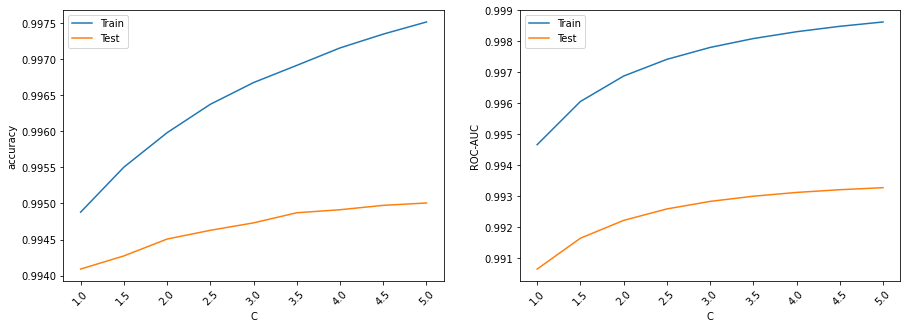

Optimal (accuracy) C - 5.0
Optimal (ROC-AUC) C - 5.0
Wall time: 54.1 s


In [65]:
%%time
c_value = np.linspace(1, 5, 9)
opt_acc, opt_auc, _ = optimizize_param(LogisticRegression(**lr_params), 
                                       "C", c_value, 
                                       X_train, y_train, X_valid, y_valid)

Оптимальный параметр регуляризации равен 2.0
- существенного прироста метрик с большими значениями не наблюдается
- меньший параметр отвечает за более агресивное противодействие переобучению

In [66]:
lr_params["C"] = 2.0
lr_opt = LogisticRegression(**lr_params)
validate_score(lr_opt, X_train, y_train, X_valid, y_valid)
lr_opt.fit(X_train_sparse, y)
lr_opt_test_pred_proba = lr_opt.predict_proba(X_test_sparse)[:, 1]
write_to_submission_file(lr_opt_test_pred_proba, "lab_answers/report_alice_LR_opt.csv")

LogisticRegression ROC-AUC on validation dataset: 0.9927741660533549
LogisticRegression accuracy on validation dataset: 0.9949692356604515


<span style="color:red">**Kaggle score: 0.96861**</span>

<span style="color:red">**Leaderboard: 21**</span>

## Результаты

Финальная модель существенно лучше Baseline c использованием SGDClassifier и стандартных признаков.

На момент окончания работы место на Public Leaderboard 21 из 4893, результат 0.96861. Лучшая модель - LogisticRegression после оптимизации параметра регуляризации C. 

Основной вклад в улучшения результата был сделан добавлением новых признаков. Так же прирост получен за счёт удаления из обучения нетипичного поведедения пользователя Alice и заполненения пропусков известными данными.

При помощи XGBClassifier были получены близкие к LogisticRegression результаты, однако они были немного хуже. Стоит попробовать другие библиотеки градиентного бустинга.